# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from mxnet.gluon.data.dataset import ArrayDataset

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, pathes_dirs=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            if pathes_dirs is not None:
                for pathes_dir in pathes_dirs:
                    pathes.extend([os.path.join(pathes_dir, f) for f in os.listdir(pathes_dir)])
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [5]:
from cifar10_utils import show_images
import utils
import os, shutil
%matplotlib inline

EPS = 1e-30

def show_data(data, clip=True):
    images = inv_normalize(data, clip=clip)
    show_images(images)
    
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)
   
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
    
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    return t
    
def inv_normalize(data, mean=None, std=None, clip=True, asnumpy=True):
    if mean is None: mean=nd.array([0.4914, 0.4822, 0.4465])
    if std is None: std=nd.array([0.2023, 0.1994, 0.2010])
    if asnumpy: 
        data, mean, std = data.asnumpy(), mean.asnumpy(), std.asnumpy()
    images = data.transpose((0, 2, 3, 1))
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images


class BackGradDataGenerator:
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
        if str(context)[:3] != "cpu":
            print "warring: data was not in CPU, the returned backgrad_data is shallow copy of data."
        
        if bn_control is not None:
            bn_control.store()

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        for iters in range(1, max_iters+1):
            with autograd.record():
                data.attach_grad()
                output = net(data)
                loss = -loss_f(output, label)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()     # reduce will make memory release

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss

            BackGradDataGenerator.SGD(data, lr)
        if bn_control is not None:
            bn_control.load()
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
    
    @staticmethod
    def generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,
                            use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                            loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=None, begin_index=0):
        out_idx, iters = begin_index, 0
        diffs, losses, MSEs, SNRs, bloss = None, None, None, None, 0
        
        bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
        bn_backup.store()
        for data, label in origin_data:
            backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data(
                net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            bloss += _bloss

            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
                
            # must copy to cpu, or will make gpu memory leak(not release)
            backgrad_data = inv_normalize(backgrad_data, clip=False, asnumpy=False)
            out_data[out_idx:out_idx+data.shape[0], :, :, :] = backgrad_data.transpose((0, 2, 3, 1)).as_in_context(mx.cpu())
            out_idx += data.shape[0]
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False))
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy())
            iters += 1
        bn_backup.load()
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs    

    @staticmethod
    def generate_data_for_dataset(net, origin_data, max_iters=10, lr=0.1, save_path=None,
                                  use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                                  loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), save_per_batch=False, data_shape=None):
        """
            1. travel all data in origin data, and get backgrad data , and save them.
            2. get same evaluate info, and return them.
        """
        all_data, all_label, iters = None, None, 0
        if (not save_per_batch) and data_shape is not None:
            all_data = nd.zeros(shape=data_shape)
            all_label = nd.zeros(shape=(data_shape[0], 1))
            data_i = 0
        diffs, losses, MSEs, SNRs = None, None, None, None
        
        bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
        bn_backup.store()
        for i, (data, label) in enumerate(origin_data):# BackGradDataGenerator
            backgrad_data, (_loss, ) = generate_backgrad_data(
                net, data.copy(), label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            SNR = 10 * nd.log10(Savg / (MSE))
            # SNR = 10 * nd.log10(Savg / (MSE+EPS))
            
            backgrad_data = nd.array(inv_normalize(backgrad_data, clip=False))
            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
            
            # save back grad image
            if save_path is not None:
                if save_per_batch: # save per batch
                    nd.save(save_path + str(i) + '.ndarray', [backgrad_data.transpose((0, 2, 3, 1)), label.astype('int64')])
                elif data_shape is not None: # use pre-malloc-memory
                    if data_shape[0] < data.shape[0]:
                        raise ValueError('data_shape[0] must >= batch size, but got data_shape[0]=' + 
                                         str(data_shape[0]) + ', batch_size=' + str(data.shape[0]))
                    if data_i + data.shape[0] > data_shape[0]:
                        nd.save(save_path + str(i) + '.ndarray', 
                                [all_data[:data_i, :, :, :].transpose((0, 2, 3, 1)), all_label[:data_i].astype('int64')])
                        data_i = 0
                    all_data[data_i:data_i+data.shape[0], :, :, :] = backgrad_data
                    all_label[data_i:data_i+data.shape[0], :] = label
                    data_i += data.shape[0]
                else:
                    all_data = backgrad_data if all_data is None else nd.concat(all_data, backgrad_data, dim=0)                        
                    all_label = label if all_label is None else nd.concat(all_label, label, dim=0)
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False))
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy())
            iters += 1
        bn_backup.load()
        
        if save_path is not None and (not save_per_batch) and data_shape is None:
            nd.save(save_path, [all_data.transpose((0, 2, 3, 1)), all_label.astype('int64')])
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs
        
    @staticmethod        
    def statistic_info(net, origin_data, max_iters=10, lr=0.1, save_path="../../tmp/backgrad_tmp.ndarray",
                       use_batch_mean_std=False, use_statistic=True, show_per_iters=None,loss_f = gluon.loss.SoftmaxCrossEntropyLoss(),
                       save_per_batch=False, data_shape=None, clear=True, **kwargs):
        """
        examples:
            '''
                origin_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
                origin_data = gluon.data.DataLoader(origin_ds, 32, shuffle=False, num_workers=4)
                net = ResNet(10)
                net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
                diff, loss, MSE, SNR, acc = BGG.statistic_info(net, origin_data, max_iters=10, lr=0.1, use_batch_mean_std=False,
                                                               show_per_iters=500, save_per_batch=True)
                # diff, loss, MSE, SNR, acc = BGG.statistic_info(net, origin_data, max_iters=10, lr=0.1, use_batch_mean_std=False,
                #                                              show_per_iters=500, save_per_batch=False, data_shape=(5000, 3, 32, 32))
                print diff
                print loss
                print MSE
                print SNR
                print acc
            '''
        """
        if (save_per_batch or data_shape is not None) and save_path=="../../tmp/backgrad_tmp.ndarray":
            save_path = '../../tmp/backgrad_tmp/'
            mkdir_if_not_exist([save_path])
        diff, loss, MSE, SNR = BackGradDataGenerator.generate_data_for_dataset(net, origin_data, max_iters, lr, save_path, use_batch_mean_std,
                                        use_statistic, show_per_iters, loss_f, save_per_batch, data_shape, **kwargs)
        if save_per_batch or data_shape is not None:
            data_path = []
            for batch_data_file in os.listdir(save_path):
                data_path.append(os.path.join(save_path, batch_data_file))
        else:
            data_path = [save_path]
        backgrad_ds = MyArrayDataset(load_all_data_label(data_path), transform=_transform_test)
        backgrad_data = gluon.data.DataLoader(backgrad_ds, 32, shuffle=False, num_workers=3)
        acc = utils.evaluate_accuracy(backgrad_data, net, ctx=ctx)
        
        if clear:
            shutil.rmtree(save_path)
        return diff, loss, MSE, SNR, acc
        
BGG = BackGradDataGenerator

origin-train[:half]: 0.0
origin-train[half:]: 0.0
0.0
1.0


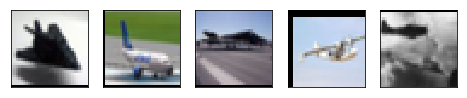

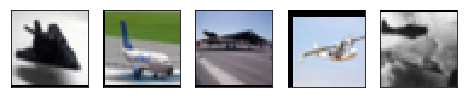

(1.7329166, 2.8471942, 0.71748167, 0.484137)
(-8.7995768, -0.00017069314, -21.071201, 6.192544)
(0.0010538374, 0.0026388394, 0.0001675716, 0.00054871594)
(33.773651, 43.007702, 25.972279, 3.5337753)
-8.79957580566
0.9765625
origin-train[:half]: 0.0
origin-train[half:]: 20.6814
143.69 143.69
65.251 77.6437


In [10]:
def test():
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_data_array, origin_label_array = origin_data_array[:128], origin_label_array[:128]
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform_train_DA1)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    data1 = None
    for d, l in train_data:
        if data1 is None:
            data1 = d.copy()
        else:
            print nd.mean(nd.abs(d - data1)).asscalar()
    
    net = ResNet(10)
    # net.initialize(ctx=ctx)
    net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    # net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(x) for x in xs])
    
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    print nd.mean(origin_ds._data[0]).asscalar(), nd.mean(train_ds._data[0][0]).asscalar()
    print np.std(origin_ds._data[0].asnumpy()), np.std(train_ds._data[0][1].asnumpy())
test()

In [6]:
origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=_transform_test)
origin_data = gluon.data.DataLoader(origin_ds, 32, shuffle=False, num_workers=1)

datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
train_ds = MyArrayDataset2(datas, transform=transform_train_DA1)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=2)
    
#     print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
#     print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    
net = ResNet(10)
net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
#net.load_params('../../models/resnet18_me_200e', ctx=ctx)
print utils.evaluate_accuracy(train_data, net, ctx)

MXNetError: [09:30:44] src/io/local_filesys.cc:166: Check failed: allow_null  LocalFileSystem::Open "/home/hui/dataset/CIFAR10/arraydataset/origin.ndarray": No such file or directory

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0x2cd412) [0x7efe10fc9412]
[bt] (1) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0x2c8f994) [0x7efe1398b994]
[bt] (2) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(+0x2c8609a) [0x7efe1398209a]
[bt] (3) /usr/local/lib/python2.7/dist-packages/mxnet/libmxnet.so(MXNDArrayLoad+0x230) [0x7efe13435f10]
[bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7efe65f89e40]
[bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7efe65f898ab]
[bt] (6) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(_ctypes_callproc+0x48f) [0x7efe661993df]
[bt] (7) /usr/lib/python2.7/lib-dynload/_ctypes.x86_64-linux-gnu.so(+0x11d82) [0x7efe6619dd82]
[bt] (8) /usr/bin/python(PyObject_Call+0x43) [0x4b0cb3]
[bt] (9) /usr/bin/python(PyEval_EvalFrameEx+0x5faf) [0x4c9faf]



In [ ]:
## mxnet reduce bug.

In [9]:
def generate_backgrad_data(net, origin_data, loss_f):
    train_loss, btime, train_acc, bloss, i, train_acc = 0, 0, 0, 0, 0, 0
    bn_backup = BNControl(net.net, True) # to avoid update moving_mean/std when generate image
    bn_backup.store()
    for data, label in origin_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)

        # generate backgrad data
        backgrad_data, (_bloss, ) = BGG.generate_backgrad_data(
                net, data.copy(), label, max_iters=10, lr=0.1, iter_log=False, clip=False, loss_f=loss_f)

    #     with autograd.record():
    #         output = net(backgrad_data)
    #         loss = loss_f(output, label)
    #     loss.backward()
    #     trainer.step(backgrad_data.shape[0])

    #     _loss = nd.mean(loss).asscalar()
    #     _acc = utils.accuracy(output, label.as_in_context(ctx))
        bloss = nd.mean(_bloss).asscalar()
    #         if not use_mixup and (back_grad_args is None or not args.has_key('soft_label_th')):
    #             _acc = utils.accuracy(output, label)

    bn_backup.load()
    
generate_backgrad_data(net, origin_data, gluon.loss.SoftmaxCrossEntropyLoss())

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data was not in CPU, the returned backgrad_data is shallow copy of data.
warring: data wa

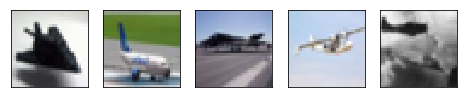

iter: 5 loss: -7.45816
iter: 10 loss: -8.89289
iter: 15 loss: -9.78117
iter: 20 loss: -10.3619
iter: 25 loss: -10.8354
iter: 30 loss: -11.1988
iter: 35 loss: -11.4819
iter: 40 loss: -11.7381
iter: 45 loss: -11.9651


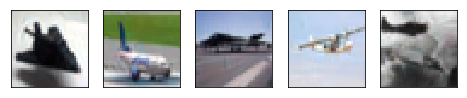

iter: 50 loss: -12.1603
iter: 55 loss: -12.3293
iter: 60 loss: -12.4818
iter: 65 loss: -12.62
iter: 70 loss: -12.7425
iter: 75 loss: -12.8553
iter: 80 loss: -12.9613
iter: 85 loss: -13.0607
iter: 90 loss: -13.1529
iter: 95 loss: -13.2403


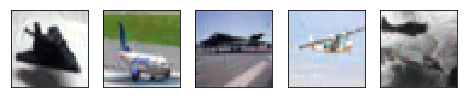

iter: 100 loss: -13.3227
cpu(0)


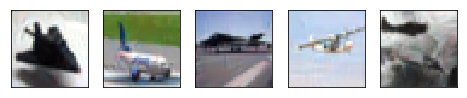

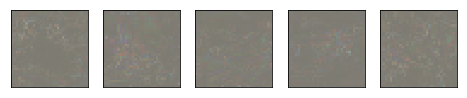


[ 0.6484642]
<NDArray 1 @cpu(0)> 
[  1.14738941e-06]
<NDArray 1 @cpu(0)> 
[ -1.86290359e+01  -2.02337646e+01  -3.03103268e-04  -2.69409356e-05
  -2.77504082e+01]
<NDArray 5 @cpu(0)>


In [6]:
if True:
    train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)

    net = ResNet(10)
    net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    #net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

    # as_in_context is deep copy, value change will not inference each other.
    for data, label in train_data:
#         data2 = data
#         print id(data2),id(data)
#         data = data.as_in_context(ctx)
#         data += 1
#         print id(data2), id(data)
#         print data2[0, 0, 0, 0].asscalar(), data[0, 0, 0, 0].asscalar()
        break
    data, label = data[range(0, 25, 5), :, :, :], label[range(0, 25, 5)]
    show_data(data, clip=False)
    backgrad_data, (loss,) = BGG.generate_backgrad_data(net, data, label, 
                                                        max_iters=100, lr=0.1, iter_log=True,
                                                    clip=False, bn_control=BNControl(net.net, use_batch=True))
    print backgrad_data.context
    show_data(backgrad_data, False)
    diff = nd.abs(data[:5] - backgrad_data[:5])
    show_data(diff, False)
    print nd.max(diff), nd.min(diff), loss

### 2. 1 about ArrayDataset
1. change dataset.\_data will not change dataloader's len, so will outbound if \_data shape changed.
2. change dataset.\_data will change the return data of dataloader

so if change shape of ArrayDataset's \_data, please reset dataloader<br/>
if just change value of ArrayDataset's \_data, needn't reset dataloader<br/>

In [6]:
def test():
    orgin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    train_ds = MyArrayDataset([orgin_data_array[:128, :, :, :], origin_label_array[:128]], transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)

    # change value will get changed value in dataloader
    print "1. chage value test:"
    print len(train_data)
    train_ds._data[0][:, :, :, :] = 2
    print train_ds._data[0].shape
    for d, l in train_data:
        print np.mean(inv_normalize(d, clip=False)), l.shape # same 
        break
    
    # change shape
    print "2. change shape test:"
    train_ds._data[0] = nd.concat(train_ds._data[0], train_ds._data[0] + 1, dim=0)
    train_ds._data[1] = np.concatenate([train_ds._data[1], train_ds._data[1]], axis=0)
    for _ in range(3):
        for d, l in train_data:
            print np.mean(inv_normalize(d, clip=False)), l.shape, # same 
        print
    print len(train_data)
    print train_ds._data[0].shape
    
    print "3. change shape and length test:"
    train_ds._length = train_ds._data[0].shape[0]
    #train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
    for d, l in train_data:
        print np.mean(inv_normalize(d, clip=False)), l.shape, # same 
    print
    print len(train_data)
    for d, l in train_data:
        print np.mean(inv_normalize(d, clip=False)), l.shape, # same 
    print
    print len(train_data)
    
    print "4. change shape and length and reset dataloader test:"
    train_ds._length = train_ds._data[0].shape[0]
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
    for d, l in train_data:
        print np.mean(inv_normalize(d, clip=False)), l.shape, # same 
    print
    print len(train_data)
    
    # slice is copy for ndarray
    ndarray = train_ds._data[0][:32, :, :, :]
    print train_ds._data[0][0, 0, 0, 0].asscalar()
    ndarray[:, :, :, :] = ndarray + 1
    print train_ds._data[0][0, 0, 0, 0].asscalar(), ndarray[0, 0, 0, 0].asscalar()
    
    ndarray2 = nd.concat(ndarray, ndarray, dim=0)
    ndarray2[:, :, :, :] = 0
    print ndarray[0, 0, 0, 0].asscalar(), ndarray2[0, 0, 0, 0].asscalar()
test()

1. chage value test:
4
(128L, 32L, 32L, 3L)
2.0 (32L, 1L)
2. change shape test:
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L)
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L)
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L)
4
(256L, 32L, 32L, 3L)
3. change shape and length test:
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L)
4
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L)
4
4. change shape and length and reset dataloader test:
2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 2.0 (32L, 1L) 3.0 (32L, 1L) 3.0 (32L, 1L) 3.0 (32L, 1L) 3.0 (32L, 1L)
8
2.0
2.0 3.0
3.0 0.0


origin-train[:half]: 0.0
origin-train[half:]: 0.0
0.999960038363


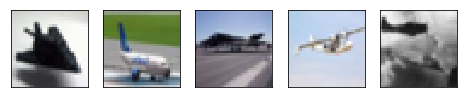

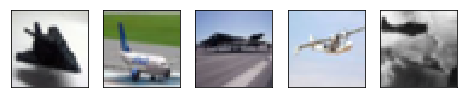

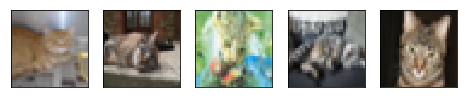

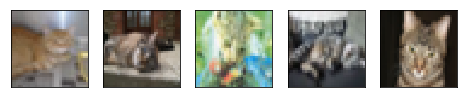

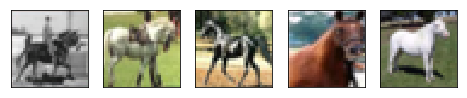

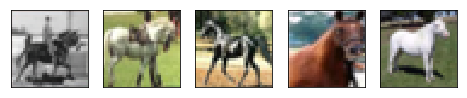

(0.010103771, 3.4806995, 0.0, 0.083376877)
(-0.0098347748, 0.0, -14.551087, 0.210365)
(2.296156e-06, 0.0039437725, 0.0, 5.5775508e-05)
(115.52301, 307.34122, 19.602964, 42.24308)
0.99962036445
origin-train[:half]: 0.0
origin-train[half:]: 3.98972e-07
120.708 120.708
64.15 64.15


In [6]:
def test():
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    # origin_data_array, origin_label_array = origin_data_array[:128, :, :, :], origin_label_array[:128]
    origin_ds = MyArrayDataset([origin_data_array, origin_label_array], transform=_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=1)
    
    train_data_array = nd.concat(origin_data_array, origin_data_array, dim=0) # copy
    train_label_array = nd.concat(origin_label_array, origin_label_array, dim=0) # copy
    train_ds = MyArrayDataset([train_data_array, train_label_array], transform=transform_train_DA1)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=2)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][:origin_ds._data[0].shape[0], :, :, :]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][origin_ds._data[0].shape[0]:, :, :, :]).asscalar()
    
    net = ResNet(10)
    net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    # net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    a, b, c, d = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=False, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0], begin_index=train_ds._length/2)
    print "\n".join([str(a), str(b), str(c), str(d)])
    
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][:origin_ds._data[0].shape[0], :, :, :]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][origin_ds._data[0].shape[0]:, :, :, :]).asscalar()
    print nd.mean(origin_ds._data[0]).asscalar(), nd.mean(train_ds._data[0][origin_ds._data[0].shape[0]:, :, :, :]).asscalar()
    print np.std(origin_ds._data[0].asnumpy()), np.std(train_ds._data[0][origin_ds._data[0].shape[0]:, :, :, :].asnumpy())
test()

origin-train[:half]: 0.0
origin-train[half:]: 0.0
0.0
1.0


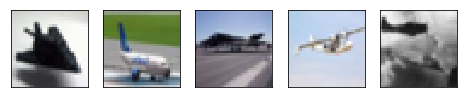

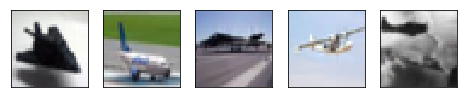

(1.9217489, 3.0568268, 0.23197122, 0.61331159)
(-10.409849, -4.0291929e-05, -23.964245, 7.2823472)
(0.0013246322, 0.0030417284, 1.7516486e-05, 0.00071235356)
(31.784838, 53.956177, 21.728649, 5.2881598)
0.9921875
origin-train[:half]: 0.0
origin-train[half:]: 0.000715262
143.69 143.69
65.251 65.2546


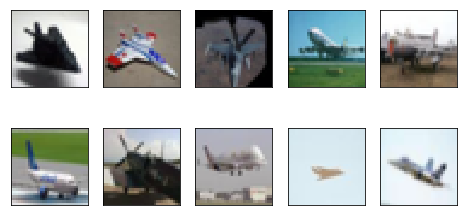

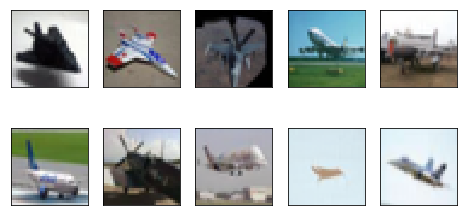

0.0235708


In [14]:
def test():
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_data_array, origin_label_array = origin_data_array[:128], origin_label_array[:128]
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    data1 = None
    for d, l in train_data:
        if data1 is None:
            data1 = d.copy()
        else:
            print nd.mean(nd.abs(d - data1)).asscalar()
    
    net = ResNet(10)
    net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    # net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    a, b, c, d = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=150,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0)
    print "\n".join([str(a), str(b), str(c), str(d)])
    
    print utils.evaluate_accuracy(train_data, net, ctx)
    
    print 'origin-train[:half]:', nd.mean(origin_ds._data[0] - train_ds._data[0][0]).asscalar()
    print 'origin-train[half:]:', nd.mean(origin_ds._data[0] - train_ds._data[0][1]).asscalar()
    print nd.mean(origin_ds._data[0]).asscalar(), nd.mean(train_ds._data[0][0]).asscalar()
    print np.std(origin_ds._data[0].asnumpy()), np.std(train_ds._data[0][1].asnumpy())
    
    data1 = None
    for d, l in train_data:
        show_data(d[:10, :, :, :])
        if data1 is None:
            data1 = d.copy()
        else:
            print nd.mean(nd.abs(d - data1)).asscalar()
test()

# 4. define train function

In [6]:
"""
train
"""
import datetime
import utils
import sys
from random import random

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False
    
    
class TrainPipeline(object):
    def __init__(self, net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers=None, 
                 output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), mixup_alpha=None,
                 back_grad_args=None):
        self.net, self.train_data, self.valid_data, self.start_epoch = net, train_data, valid_data, start_epoch
        self.num_epochs, self.policy, self.ctx, self.w_key, self.trainers = num_epochs, policy, ctx, w_key, trainers
        self.output_file, self.verbose, self.loss_f, self.mixup_alpha = output_file, verbose, loss_f, mixup_alpha
        self.back_grad_args = back_grad_args
        
    def initialize(self):
        """
            invoke before train
            1. reset output file
            2. set prev_time for cal cost time
            3. init trainers
            4. verbose set True print test_acc in valid_data
        """
        if self.output_file is None:
            self.output_file = sys.stdout
            self.stdout = sys.stdout
        else:
            self.output_file = open(self.output_file, "w")
            self.stdout = sys.stdout
            sys.stdout = self.output_file
       
        self.prev_time = datetime.datetime.now()

        if self.verbose:
            print " #", utils.evaluate_accuracy(self.valid_data, self.net, self.ctx)
            
        if self.trainers is None:
            self.trainers = [gluon.Trainer(self.net.collect_params(), 'sgd', 
                                  {'learning_rate': self.policy['lr'], 'momentum': 0.9, 'wd': self.policy['wd']})]
    
    def after_epoch(self, epoch, train_loss, train_acc):
        """
            invoke after every epoch of train
            1. cal and print cost time the epoch
            2. print acc/loss info
            3. print lr
            4. update lr
        """
        # log info
        self.cur_time = datetime.datetime.now()
        h, remainder = divmod((self.cur_time - self.prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)

        train_loss /= len(self.train_data)
        train_acc /= len(self.train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(self.train_data, self.net, self.ctx)

        if self.valid_data is not None:
            valid_acc = utils.evaluate_accuracy(self.valid_data, self.net, self.ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        
        self.prev_time = self.cur_time
        
        self.output_file.write(epoch_str + ", " + time_str + ",lr " + str([trainer.learning_rate for trainer in self.trainers]) + "\n")
        self.output_file.flush()  # to disk only when flush or close
        
        if in_list(epoch+1, self.policy['lr_period']):
            for trainer in self.trainers:
                trainer.set_learning_rate(trainer.learning_rate * self.policy['lr_decay'])
    
    def after_iter(self, i, _loss, _acc):
        """
            invoke after every iteration
            1. print iter losss and acc
            2. print weight and grad for every iter
        """
        if self.verbose:
            print " # iter", i,
            print "loss %.5f" % _loss, "acc %.5f" % _acc,
            print "w (",
            for k in self.w_key:
                w = self.net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in self.w_key:
                w = self.net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        
    def run(self):
        self.initialize()
        for epoch in range(self.start_epoch, self.start_epoch+self.num_epochs):
            train_loss, train_acc, i = 0., 0., 0
            for data, label in self.train_data:
                with autograd.record():
                    data, label = data.as_in_context(ctx), label.as_in_context(ctx)
                    output = self.net(data)
                    loss = self.loss_f(output, label)
                loss.backward()
                for trainer in self.trainers:
                    trainer.step(data.shape[0])
                
                _loss = nd.mean(loss).asscalar() 
                _acc = utils.accuracy(output, label)
                train_loss += _loss
                train_acc += _acc
                
                self.after_iter(i, _loss, _acc)
                i += 1
            self.after_epoch(epoch, train_loss, train_acc)
        
        if self.output_file == sys.stdout:
            sys.stdout = self.stdout
            self.output_file.close()

#### BN train\_and\_no\_global\_stat:
1. use batch mean/std.
2. change moving_mean/std same as change momentum(0.9->0.35).

#### in before analysis to this wrong condition, we can know:
1. generate images use batch mean/std, but not inference by moving_mean/std.
2. test set acc inference by moving_mean/std, but not inference by batch mean/std.
3. use batch std can explain why shuffle infrence huge, bigger batch std(use shuffle) get sammmer grad, so get smaller diif on orign image, it acturally inference result by infrence diff. and shuffle will get moving_mean more represnet cause momentum come small(0.35)
4. but batch std is not same as just change lr, it will get small diff std while keep big mean.

#### so there some choices:
all condition, we need not update moving_mean/std when generate backgrad images.
1. not use batch mean/std to gennerate image, just set lr and max_iter to control diff/MSE and so on. (use_global_stas=True)
2. use batch mean/std, set shuffle, batch_size to get smaller std while get same mean. (save runing_mean/std before op and then load after)

In [7]:
class BackGradTrain(TrainPipeline):
    """
        1. add loss and diff/MSE/SNR to evaluate and control generate images
        2. BN layer: set use_gloabl_stats=True to use global mean/std and stop moving mean cal when genarate images, and set False after geneate.
        3. using DA after genereate images, means no DA when generate images
        4.
    """
    def __init__(self, net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers=None, 
                 output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), mixup_alpha=None,
                 back_grad_args=None):
        super(BackGradTrain, self).__init__(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx,
                                            w_key, trainers, output_file, verbose, loss_f, mixup_alpha, back_grad_args) 
        
    def initialize(self):
        super(BackGradTrain, self).initialize()
        if self.back_grad_args is not None:
            self.back_grad_args['num_epoch_per_round'] = self.back_grad_args.get('num_epoch_per_round', 1)
            self.back_grad_args['verbose'] = self.back_grad_args.get('verbose', False)
    
    def after_epoch(self, epoch, train_loss, train_acc):
        super(BackGradTrain, self).after_epoch(epoch, train_loss, train_acc)
    
    def after_iter(self, i, _loss, _acc):
        super(BackGradTrain, self).after_iter(i, _loss, _acc)
    
    def statistic(self, diffs):
        t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
        return t
      
    def run(self):
        self.initialize()
        if self.back_grad_args is not None:
            num_epoch_per_round = self.back_grad_args['num_epoch_per_round']
            max_iters, lr = self.back_grad_args['max_iters'], self.back_grad_args['lr']
            origin_data, b_verbose = self.back_grad_args['origin_data'], self.back_grad_args['verbose']
            use_batch_mean_std, train_ds = self.back_grad_args['use_batch_mean_std'], self.back_grad_args['train_ds']
        epoch_round = 0
        
        for epoch in range(self.start_epoch, self.start_epoch+self.num_epochs):
            # 1. train net
            train_loss, train_acc, i = 0., 0., 0
            for data, label in self.train_data:
                with autograd.record():
                    data, label = data.as_in_context(ctx), label.as_in_context(ctx)
                    output = self.net(data)
                    loss = self.loss_f(output, label)
                loss.backward()
                for trainer in self.trainers:
                    trainer.step(data.shape[0])

                _loss = nd.mean(loss).asscalar() 
                _acc = utils.accuracy(output, label)
                train_loss += _loss
                train_acc += _acc

                self.after_iter(i, _loss, _acc)
                i += 1
                
            # 2. generate new backgrad data
            if self.back_grad_args is not None and (epoch - self.start_epoch + 1) % num_epoch_per_round == 0:
                diff, gloss, MSE, SNR = BGG.generate_data_for_out(self.net, origin_data, max_iters, lr, use_batch_mean_std,
                                            True, None, loss_f, out_data=train_ds._data[0][1], begin_index=0)
                
                if b_verbose:
                    print "# epoch_round, generate data info (mean, max, min, std):", epoch_round
                    print "#     diff:", diff
                    print "#     loss:", gloss
                    print "#     MSE :", MSE
                    print "#     SNR :", SNR
                epoch_round += 1
                
            self.after_epoch(epoch, train_loss, train_acc)
            
        if self.output_file == sys.stdout:
            sys.stdout = self.stdout
            self.output_file.close()
            
def data_loader2(batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2]):
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform[0])
    origin_data = gluon.data.DataLoader(origin_ds, batch_size[0], shuffle=False, num_workers=num_workers[0])
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform[1])
    train_data = gluon.data.DataLoader(train_ds, batch_size[1], shuffle=True, num_workers=num_workers[1])
    
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform[2])
    test_data = gluon.data.DataLoader(test_ds, batch_size[2], shuffle=False, last_batch='keep', num_workers=num_workers[2])
    return (origin_data, train_data, test_data), (origin_ds, train_ds, test_ds)

# 5. get net and do EXP

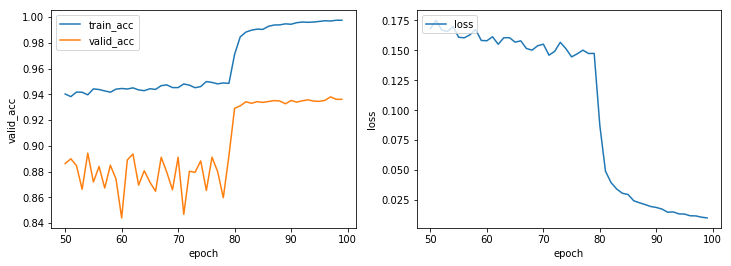

lr [0.1, 0.01, 0.001]


In [13]:
update('../../log/resnet18_me_200e.log', x_range=(50, 100))
# show_log('../../log/resnet18_me_200e.log')

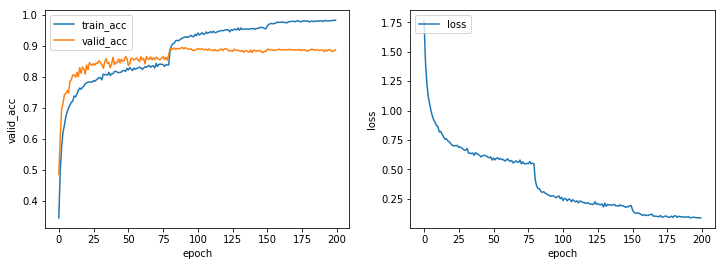

lr [0.1, 0.01, 0.001]


In [11]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log', x_range=(0, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log')

##  5.2 simple test ,use_batch_mean_std=True/False

In [8]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train8_resnet18_r1_i10_lr01_bT.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 1, 1])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': True, 'train_ds': train_ds}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()

net.save_params("../../models/train8_resnet18_r1_i10_lr01_bT")

In [ ]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

start_epoch=0
num_epochs = 100
policy = {'lr': 0.1, 'wd': 1e-4, 'lr_decay': 0.1, 'lr_period': [40, 75]}
w_key = []
trainers = None
log_file = "../../log/train8_resnet18_r1_i10_lr01_bF.log"
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

(origin_data, train_data, valid_data), (_, train_ds, _) = data_loader2(
    batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 4, 4])


back_grad_args = {'num_epoch_per_round': 1, 'max_iters': 10, 'lr': 0.1, 'origin_data': origin_data, 
                  'verbose': True, 'use_batch_mean_std': False, 'train_ds': train_ds}

BackGradTrain(net, train_data, valid_data, start_epoch, num_epochs, policy, ctx, w_key, trainers, 
                 log_file, verbose=False, loss_f=loss_f, mixup_alpha=None, back_grad_args=back_grad_args).run()
net.save_params("../../models/train8_resnet18_r1_i10_lr01_bF")

In [1]:
net.save_params("../../models/train8_resnet18_r1_i10_lr01_bF")

NameError: name 'net' is not defined